<a href="https://colab.research.google.com/github/edgarbc/patient_analyzer/blob/main/MedPatientEmbeddingVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Patient Embedding and Visualization
Google Colab notebook to compare medical patients using a pre-trained BERT model and visualize their similarity based on embeddings using t-SNE.

Make sure to change the run type to a T4 (GPU).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edgarbc/patient_analyzer/blob/main/notebooks/med_patient_embed.ipynb)
[![GitHub](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/edgarbc/patient_analyzer)


In [ ]:

# Step 1: Install Required Libraries
!pip install transformers torch scikit-learn matplotlib


In [13]:

# Step 2: Import Libraries
import random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE
import numpy as np

In [5]:
# Step 3: Generate Synthetic Patient Data
conditions = ['hypertension', 'diabetes', 'asthma', 'arthritis', 'heart disease', 'cancer']
medications = ['metformin', 'lisinopril', 'albuterol', 'ibuprofen', 'atorvastatin', 'aspirin']
procedures = ['angioplasty', 'colonoscopy', 'MRI', 'CT scan', 'blood test', 'surgery']

# function to generate a random patient that receives the values of the parameters
def create_patient(age:int, gender:str, conditions:list, medications:list, procedures:list):
    return {
        'age': age,
        'gender': gender,
        'conditions': conditions,
        'medications': medications,
        'procedures': procedures
    }



In [26]:
# generate 3 populations of random patients with close values
import random

pop1_size = 30

young_healthy_males = []
young_healthy_females = []
old_unhealthy_males = []
old_unhealthy_females = []

# young healthy males
for i in range(pop1_size):
  young_healthy_males.append(create_patient(
      age = random.randint(20, 30),
      gender = 'male',
      conditions = random.sample(conditions, random.randint(1, 2)),
      medications = random.sample(medications, random.randint(1, 1)),
      procedures = random.sample(procedures, random.randint(1, 2))
    )
  )

# young health females
pop2_size = 30
for i in range(pop2_size):
  young_healthy_females.append(create_patient(
      age = random.randint(20, 30),
      gender = 'female',
      conditions = random.sample(conditions, random.randint(1, 2)),
      medications = random.sample(medications, random.randint(1, 1)),
      procedures = random.sample(procedures, random.randint(1, 2))
    )
  )

# old unhealthy males
pop3_size = 30
for i in range(pop3_size):
  old_unhealthy_males.append(create_patient(
      age = random.randint(60, 80),
      gender = 'male',
      conditions = random.sample(conditions, random.randint(1, 6)),
      medications = random.sample(medications, random.randint(1, 6)),
      procedures = random.sample(procedures, random.randint(1, 6))
    )
  )

# old unhealthy females
pop4_size = 30
for i in range(pop4_size):
  old_unhealthy_females.append(create_patient(
      age = random.randint(60, 80),
      gender = 'female',
      conditions = random.sample(conditions, random.randint(1, 6)),
      medications = random.sample(medications, random.randint(1, 6)),
      procedures = random.sample(procedures, random.randint(1, 6))
    )
  )


print(f"young healthy males: {len(young_healthy_males)}")
print(f"young healthy females: {len(young_healthy_females)}")
print(f"old unhealthy males: {len(old_unhealthy_males)}")
print(f"old unhealthy females: {len(old_unhealthy_females)}")


young healthy males: 30
young healthy females: 30
old unhealthy males: 30
old unhealthy females: 30


In [27]:
# now create a list of patients with all the generated populations
patients = young_healthy_males + young_healthy_females + old_unhealthy_males + old_unhealthy_females
#
print(f"number of patients: {len(patients)}")


number of patients: 120


In [28]:

# Step 4: Convert Patient Data to Text for Embedding
def patient_to_text(patient):
    return f"Patient is a {patient['age']} year old {patient['gender']} with conditions: {', '.join(patient['conditions'])}, " \
           f"taking medications: {', '.join(patient['medications'])}, and has undergone procedures: {', '.join(patient['procedures'])}."

# Convert all patients to text descriptions
patient_texts = [patient_to_text(patient) for patient in patients]

In [29]:
print(patient_texts)

['Patient is a 27 year old male with conditions: asthma, heart disease, taking medications: atorvastatin, and has undergone procedures: MRI, CT scan.', 'Patient is a 27 year old male with conditions: diabetes, cancer, taking medications: atorvastatin, and has undergone procedures: blood test, angioplasty.', 'Patient is a 30 year old male with conditions: cancer, taking medications: atorvastatin, and has undergone procedures: angioplasty, MRI.', 'Patient is a 28 year old male with conditions: heart disease, taking medications: atorvastatin, and has undergone procedures: surgery.', 'Patient is a 29 year old male with conditions: arthritis, taking medications: lisinopril, and has undergone procedures: blood test.', 'Patient is a 28 year old male with conditions: hypertension, cancer, taking medications: atorvastatin, and has undergone procedures: blood test, angioplasty.', 'Patient is a 28 year old male with conditions: arthritis, cancer, taking medications: atorvastatin, and has undergon

In [14]:


# Step 5: Load Pre-trained BERT Model (Bio_ClinicalBERT)
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Step 6: Function to Embed Patient Data Using BERT
def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings to get a fixed-size representation
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [45]:
embeddings_patient = []
# Compute embeddings for all patients
for i,patient in enumerate(patient_texts):
    print(f"patient {i}: {patient}")

    embeddings_patient.append(embed_text(patient))





patient 0: Patient is a 27 year old male with conditions: asthma, heart disease, taking medications: atorvastatin, and has undergone procedures: MRI, CT scan.
patient 1: Patient is a 27 year old male with conditions: diabetes, cancer, taking medications: atorvastatin, and has undergone procedures: blood test, angioplasty.
patient 2: Patient is a 30 year old male with conditions: cancer, taking medications: atorvastatin, and has undergone procedures: angioplasty, MRI.
patient 3: Patient is a 28 year old male with conditions: heart disease, taking medications: atorvastatin, and has undergone procedures: surgery.
patient 4: Patient is a 29 year old male with conditions: arthritis, taking medications: lisinopril, and has undergone procedures: blood test.
patient 5: Patient is a 28 year old male with conditions: hypertension, cancer, taking medications: atorvastatin, and has undergone procedures: blood test, angioplasty.
patient 6: Patient is a 28 year old male with conditions: arthritis, c

In [32]:
# Convert the list of embeddings to a NumPy array
patient_embeddings = np.array(embeddings_patient) # Convert to numpy array

# print the size of the patient embeddings
print(patient_embeddings.shape)


(120, 768)


In [39]:

# Step 7: Apply t-SNE to Reduce Dimensionality
tsne = TSNE(n_components=2, random_state=55, perplexity=3)
embeddings_2d = tsne.fit_transform(patient_embeddings)



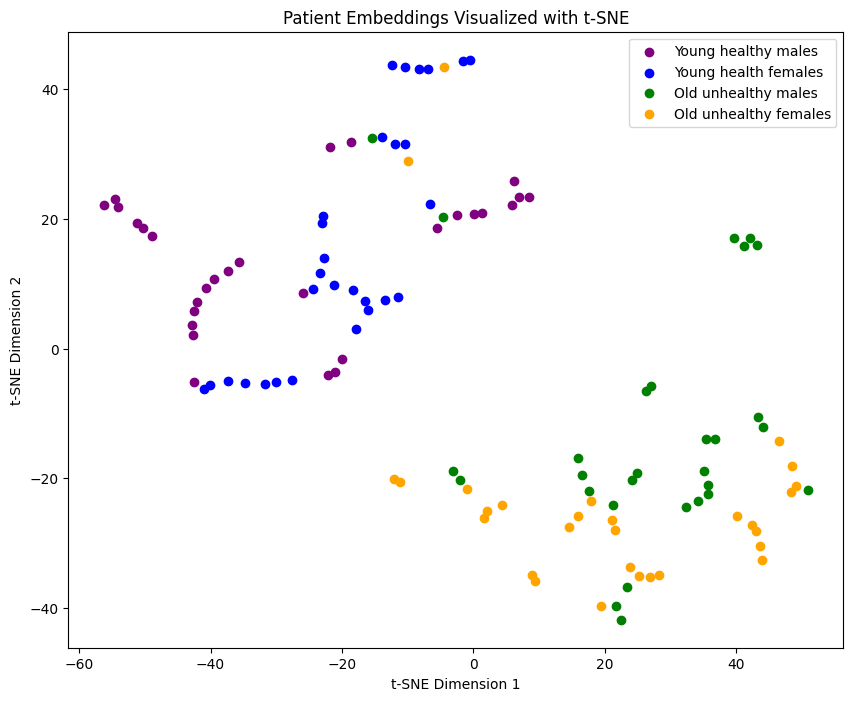

In [44]:
# display the four patient populations with different colors.
# The first 30 is population 1, the second 30 is population 2, the next 30 are population 3 and the final 30 are population 4.

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[0:29, 0], embeddings_2d[0:29, 1], color="purple")
plt.scatter(embeddings_2d[30:59, 0], embeddings_2d[30:59, 1], color="blue")
plt.scatter(embeddings_2d[60:89, 0], embeddings_2d[60:89, 1], color="green")
plt.scatter(embeddings_2d[90:119, 0], embeddings_2d[90:119, 1], color="orange")
plt.legend(["Young healthy males", "Young health females", "Old unhealthy males", "Old unhealthy females"])
plt.title('Patient Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


